# Harmonic Regression with Fourier Terms and ARIMA Errors

This model is a Regression model with Fourier terms and ARIMA errors.  The regression model consists of a fourier terms and categorical variable representing 'new years day'. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#forecast error metrics
from forecast_tools.metrics import (mean_absolute_scaled_error, 
                                    root_mean_squared_error,
                                    symmetric_mean_absolute_percentage_error)

#auto_arima
from pmdarima import auto_arima, ARIMA


import warnings
warnings.filterwarnings('ignore')

In [2]:
#helper classes for cv of exp smoothing
from amb_forecast.interop import (StatsModelsForecastObject, HoltsWinters, 
                                  StateSpaceExponentialSmoothing, 
                                  StateSpaceARIMA)

In [3]:
from amb_forecast.feature_engineering import featurize_time_series

In [4]:
#ensemble learning
from amb_forecast.ensemble import (Ensemble, UnweightedVote, 
                                   RandomForestMetaLearner)

# Input Data

In [57]:
TOP_LEVEL = '../../../results/model_selection'
STAGE = 'stage1'
REGION = 'Trust'
METHOD = 'harmonic'

FILE_NAME = 'Daily_Responses_5_Years_2019_full.csv'

#split training and test data.
TEST_SPLIT_DATE = '2019-01-01'

#second subdivide: train and val
VAL_SPLIT_DATE = '2017-07-01'

#discard data after 2020 due to coronavirus
#this is the subject of a seperate study.
DISCARD_DATE = '2020-01-01'

In [6]:
#read in path
path = f'../../../data/{FILE_NAME}'

In [7]:
def pre_process_daily_data(path, index_col, by_col, 
                           values, dayfirst=False):
    '''
    Daily data is stored in long format.  Read in 
    and pivot to wide format so that there is a single 
    colmumn for each regions time series.
    '''
    df = pd.read_csv(path, index_col=index_col, parse_dates=True, 
                     dayfirst=dayfirst)
    df.columns = map(str.lower, df.columns)
    df.index.rename(str(df.index.name).lower(), inplace=True)
    
    clean_table = pd.pivot_table(df, values=values.lower(), 
                                 index=[index_col.lower()],
                                 columns=[by_col.lower()], aggfunc=np.sum)
    
    clean_table.index.freq = 'D'
    
    return clean_table

In [8]:
clean = pre_process_daily_data(path, 'Actual_dt', 'ORA', 'Actual_Value', 
                               dayfirst=False)
clean.head()

ora,BNSSG,Cornwall,Devon,Dorset,Gloucestershire,OOA,Somerset,Trust,Wiltshire
actual_dt,,,,,,,,,
2013-12-30,415.0,220.0,502.0,336.0,129.0,NaN,183.0,2042.0,255.0
2013-12-31,420.0,236.0,468.0,302.0,128.0,NaN,180.0,1996.0,260.0
2014-01-01,549.0,341.0,566.0,392.0,157.0,NaN,213.0,2570.0,351.0
2014-01-02,450.0,218.0,499.0,301.0,115.0,NaN,167.0,2013.0,258.0
2014-01-03,419.0,229.0,503.0,304.0,135.0,NaN,195.0,2056.0,269.0


In [9]:
lags, seasonal, exceptional = featurize_time_series(y=clean[REGION])

## Train Test Split

In [10]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [11]:
train, test = ts_train_test_split(clean, split_date=TEST_SPLIT_DATE)

#exclude data after 2020 due to coronavirus.
test, discard = ts_train_test_split(test, split_date=DISCARD_DATE)


#train split into train and validation
train, val = ts_train_test_split(train, split_date=VAL_SPLIT_DATE)

In [12]:
train.shape

(1279, 9)

In [13]:
test.shape

(365, 9)

# Exognenous variables

In [14]:
def create_exogenous(k, include_new_year=True):
    exog = pd.DataFrame({'date': clean.index})
    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

    #fourier terms
    for i in range(k):
        exog[f'sin365_{i}'] = np.sin((2+(2*i)) * np.pi 
                                     * exog.index.dayofyear / 365.25)
        exog[f'cos365_{i}'] = np.cos((2+(2*i)) * np.pi 
                                     * exog.index.dayofyear / 365.25)

    #new year holiday
    if include_new_year:
        exog['new_year'] = exceptional.to_numpy()

    exog = exog.drop(columns=['date'])
    
    return exog
    
    

In [15]:
exog = create_exogenous(6)
exog_to_train, exog_to_test = ts_train_test_split(exog, 
                                                  split_date=TEST_SPLIT_DATE)
exog_to_train, exog_to_val = ts_train_test_split(exog_to_train, 
                                                 split_date=VAL_SPLIT_DATE)

exog_to_train.head()

,sin365_0,cos365_0,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,sin365_4,cos365_4,sin365_5,cos365_5,new_year
date,,,,,,,,,,,,,
2013-12-30,-0.021501,0.999769,-0.042993,0.999075,-0.064464,0.997920,-0.085906,0.996303,-0.107308,0.994226,-0.128661,0.991689,0
2013-12-31,-0.004301,0.999991,-0.008601,0.999963,-0.012901,0.999917,-0.017202,0.999852,-0.021501,0.999769,-0.025801,0.999667,0
2014-01-01,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,0.103031,0.994678,1
2014-01-02,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,0.204966,0.978769,0
2014-01-03,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,0.304719,0.952442,0


# Model selection (number of fourier terms to include)

Note this code will take several minutes (~10-15) to run (auto_arima is in parrallel)

In [16]:
min_aic = np.inf
max_k = 6
best_parameters = {'k':np.inf, 
                   'order':(),
                   'seasonal_order':()}

fitted_models = []

print(f'k:', end=' ')
for k in range(max_k):
    print(f'{k+1}', end= ', ')
    exog = create_exogenous(k+1)
    exog_to_train, exog_to_test = ts_train_test_split(exog, 
                                                      split_date='2019-01-01')
    exog_to_train, exog_to_val = ts_train_test_split(exog_to_train, 
                                                     split_date='2017-07-01')
    
    
    arima_exog_model = auto_arima(y=train['Trust'], 
                                  exogenous=exog_to_train, 
                                  seasonal=True, 
                                  m=7, 
                                  n_jobs=-1)

    if arima_exog_model.aic() < min_aic:
        min_aic = arima_exog_model.aic()
        best_parameters['k'] = k+1
        best_parameters['order'] = arima_exog_model.order
        best_parameters['seasonal_order'] = arima_exog_model.seasonal_order
        
    fitted = {'k':k+1,
              'order':arima_exog_model.order,
              'seasonal_order':arima_exog_model.seasonal_order,
              'aic': arima_exog_model.aic()}
                    
    fitted_models.append(fitted)

print('done')
print(f'model with lowest AIC {best_parameters}')

k: 1, 2, 3, 4, 5, 6, done
model with lowest AIC {'k': 1, 'order': (2, 1, 3), 'seasonal_order': (1, 0, 1, 7)}


In [17]:
fitted_models

[{'k': 1,
  'order': (2, 1, 3),
  'seasonal_order': (1, 0, 1, 7),
  'aic': 14719.659539352124},
 {'k': 2,
  'order': (1, 1, 2),
  'seasonal_order': (1, 0, 1, 7),
  'aic': 14721.321754819272},
 {'k': 3,
  'order': (1, 1, 2),
  'seasonal_order': (1, 0, 1, 7),
  'aic': 14738.430075434511},
 {'k': 4,
  'order': (5, 1, 0),
  'seasonal_order': (2, 0, 1, 7),
  'aic': 14736.171244502366},
 {'k': 5,
  'order': (1, 1, 2),
  'seasonal_order': (1, 0, 1, 7),
  'aic': 14747.484738966295},
 {'k': 6,
  'order': (1, 1, 2),
  'seasonal_order': (1, 0, 1, 7),
  'aic': 14750.48852150718}]

# Best Parameters and example model fitting and prediction

In [41]:
exog = create_exogenous(k=best_parameters['k'])
exog_to_train, exog_to_test = ts_train_test_split(exog, 
                                                  split_date=TEST_SPLIT_DATE)
exog_to_train, exog_to_val = ts_train_test_split(exog_to_train, 
                                                 split_date=VAL_SPLIT_DATE)
model = ARIMA(order=best_parameters['order'], 
              seasonal_order=best_parameters['seasonal_order'],
              enforce_stationarity=False, 
              suppress_warnings=True)

In [42]:
model.fit(train[REGION], exogenous=exog_to_train)

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [43]:
y_hat, interval = model.predict(n_periods=365, exogenous=exog_to_val[:365], 
                                return_conf_int=True, alpha=0.2)

In [44]:
forecast = pd.DataFrame(y_hat, index=val.iloc[:365].index)
forecast.columns = ['point_forecast']

In [45]:
intervals = pd.DataFrame(interval, index=val.iloc[:365].index)
intervals.columns = ['lower', 'upper']
intervals.head()

,lower,upper
actual_dt,,
2017-07-01,2162.837457,2388.935428
2017-07-02,2131.701225,2379.424239
2017-07-03,2040.465415,2297.354467
2017-07-04,1967.803225,2231.515173
2017-07-05,1963.217485,2230.975946


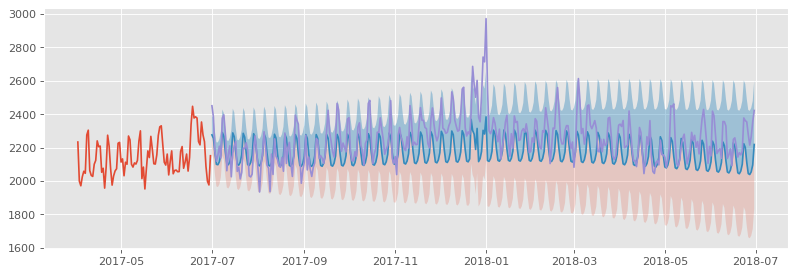

In [46]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 4), dpi=80, facecolor='w')


plt.plot(train[REGION].iloc[-90:])
plt.plot(forecast)
plt.plot(val[REGION].iloc[:365])
#plt.plot(intervals.iloc[:365])
plt.fill_between(intervals.index, intervals['lower'], 
                 forecast['point_forecast'], alpha=0.2)
plt.fill_between(intervals.index, forecast['point_forecast'], 
                 intervals['upper'], alpha=0.4)

## Time Series Cross Validation

`time_series_cv` implements rolling forecast origin cross validation for time series.  
It does not calculate forecast error, but instead returns the predictions, pred intervals and actuals in an array that can be passed to any forecast error function. (this is for efficiency and allows additional metrics to be calculated if needed).

In [47]:
def time_series_cv(model, y_train, X_train, y_val, X_val, horizons, alpha=0.2, 
                   step=1):
    '''
    Time series cross validation across multiple horizons for a single model.

    Incrementally adds additional training data to the model and tests
    across a provided list of forecast horizons. Note that function tests a
    model only against complete validation sets.  E.g. if horizon = 15 and 
    len(val) = 12 then no testing is done.  In the case of multiple horizons
    e.g. [7, 14, 28] then the function will use the maximum forecast horizon
    to calculate the number of iterations i.e if len(val) = 365 and step = 1
    then no. iterations = len(val) - max(horizon) = 365 - 28 = 337.
    
    Parameters:
    --------
    model: forecasting model

    y_train: np.array
        vector of y training data
        
    X_train: array-like
        matrix of X training data

    y_val: np.array
        vector of y validation data
        
    X_val: array-like
        matrix of X validation data

    horizon: list of ints, 
        forecast horizon e.g. [7, 14, 28] days

    step : int, optional (default=1)
        step taken in cross validation 
        e.g. 1 in next cross validation training data includes next point 
        from the validation set.
        e.g. 7 in the next cross validation training data includes next 7 points
        
            
    Returns:
    -------
    tuple: np.ndarray, np.ndarray, np.ndarray    
        predictions, validation_set, prediction_intervals
    '''
    cv_preds = [] #mean forecast
    cv_actuals = [] # actuals 
    cv_pis = [] #prediction intervals
    split = 0

    print('split => ', end="")
    for i in range(0, len(val) - max(horizons) + 1, step):
        split += 1
        print(f'{split}, ', end="")
        
        #create new training y value and exogenous variables
        y_train_cv = np.concatenate([y_train.iloc[:], 
                                     y_val.iloc[:i]], axis=0)   
        
        X_train_cv = np.concatenate([X_train.iloc[:,1:], 
                                     X_val.iloc[:i,1:]], axis=0)
                
        model.fit(y_train_cv, exog=X_train_cv)
        
        
        #create validation X values.
        horizon=len(y_val[i:i+max(horizons)])
        X_val_cv = X_val.iloc[i:i+horizon,1:]
        
        #predict the maximum horizon 
        preds, pis = model.predict(n_periods=horizon, 
                                   exogenous=X_val_cv,
                                   return_conf_int=True,
                                   alpha=alpha)
        cv_h_preds = []
        cv_test = []
        cv_h_pis = []
        
        for h in horizons:
            #store the h-step prediction
            cv_h_preds.append(preds[:h-1])
            #store the h-step actual value
            cv_test.append(y_val.iloc[i:i+h-1])    
            cv_h_pis.append(pis[:h-1])
                     
        cv_preds.append(cv_h_preds)
        cv_actuals.append(cv_test)
        cv_pis.append(cv_h_pis)
        
    print('done.\n')        
    return cv_preds, cv_actuals, cv_pis

## Custom functions for calculating CV scores for point predictions and coverage.

These functions have been written to work with the output of `time_series_cv`

In [53]:
def split_cv_error(cv_preds, cv_test, error_func):
    '''
    Forecast error in the current split
    
    Params:
    -----
    cv_preds, np.array
        Split predictions
        
    
    cv_test: np.array
        acutal ground truth observations
        
    error_func: object
        function with signature (y_true, y_preds)
        
    Returns:
    -------
        np.ndarray
            cross validation errors for split
    '''
    n_splits = len(cv_preds)
    cv_errors = []
    
    for split in range(n_splits):
        pred_error = error_func(cv_test[split], cv_preds[split])
        cv_errors.append(pred_error)
        
    return np.array(cv_errors)

def forecast_errors_cv(cv_preds, cv_test, error_func):
    '''
    Forecast errors by forecast horizon
    
    Params:
    ------
    cv_preds: np.ndarray
        Array of arrays.  Each array is of size h representing
        the forecast horizon specified.
        
    cv_test: np.ndarray
        Array of arrays.  Each array is of size h representing
        the forecast horizon specified.
        
    error_func: object
        function with signature (y_true, y_preds)
        
    Returns:
    -------
    np.ndarray
        
    '''
    cv_test = np.array(cv_test)
    cv_preds = np.array(cv_preds)
    n_horizons = len(cv_test)    
    
    horizon_errors = []
    for h in range(n_horizons):
        split_errors = split_cv_error(cv_preds[h], cv_test[h], error_func)
        horizon_errors.append(split_errors)

    return np.array(horizon_errors)

def split_coverage(cv_test, cv_intervals):
    n_splits = len(cv_test)
    cv_errors = []
        
    for split in range(n_splits):
        val = np.asarray(cv_test[split])
        lower = cv_intervals[split].T[0]
        upper = cv_intervals[split].T[1]
        
        coverage = len(np.where((val > lower) & (val < upper))[0])
        coverage = coverage / len(val)
        
        cv_errors.append(coverage)
        
    return np.array(cv_errors)
    
    
def prediction_int_coverage_cv(cv_test, cv_intervals):
    cv_test = np.array(cv_test)
    cv_intervals = np.array(cv_intervals)
    n_horizons = len(cv_test)    
    
    horizon_coverage = []
    for h in range(n_horizons):
        split_coverages = split_coverage(cv_test[h], cv_intervals[h])
        horizon_coverage.append(split_coverages)

    return np.array(horizon_coverage)  

In [54]:
def split_cv_error_scaled(cv_preds, cv_test, y_train):
    n_splits = len(cv_preds)
    cv_errors = []
    
    for split in range(n_splits):
        pred_error = mean_absolute_scaled_error(cv_test[split], cv_preds[split], 
                                                y_train, period=7)
        
        cv_errors.append(pred_error)
        
    return np.array(cv_errors)

def forecast_errors_cv_scaled(cv_preds, cv_test, y_train):
    cv_test = np.array(cv_test)
    cv_preds = np.array(cv_preds)
    n_horizons = len(cv_test)    
    
    horizon_errors = []
    for h in range(n_horizons):
        split_errors = split_cv_error_scaled(cv_preds[h], cv_test[h], y_train)
        horizon_errors.append(split_errors)
        
    return np.array(horizon_errors)

# Code for creating model and running tscv

In [50]:
def get_harmonic_regression(fitted_models, k, include_new_year=True):
    '''
    Create ensemble model.
    
    Returns:
    ARIMA, ndarray, ndarray, ndarray
    model, exog_train, exog_val, exog_test
    '''
    parameters = fitted_models[k]
    
    exog = create_exogenous(k=k, include_new_year=include_new_year)
    exog_to_train, exog_to_test = ts_train_test_split(exog, 
                                                      split_date=TEST_SPLIT_DATE)
    exog_to_train, exog_to_val = ts_train_test_split(exog_to_train, 
                                                     split_date=VAL_SPLIT_DATE)
    model = ARIMA(order=parameters['order'], 
                  seasonal_order=parameters['seasonal_order'],
                  enforce_stationarity=False, 
                  suppress_warnings=True)
    
    return model, exog_to_train, exog_to_val, exog_to_test
    

Run twice.  First time produce 80% PIs and 2nd 95%PIs.

In [51]:
horizons = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 365]
model, X_train, X_val, X_test = get_harmonic_regression(fitted_models, 
                                                        best_parameters['k'])
results = time_series_cv(model,
                         y_train=train[REGION], 
                         X_train=X_train,
                         y_val=val[REGION], 
                         X_val=X_val,
                         horizons=horizons, 
                         alpha=0.2, 
                         step=7)

split => 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, done.



## symmetric MAPE

In [58]:
cv_preds, cv_test, cv_intervals = results

#CV point predictions smape
cv_errors = forecast_errors_cv(cv_preds, cv_test, 
                               symmetric_mean_absolute_percentage_error)
df = pd.DataFrame(cv_errors)
df.columns = horizons
df.describe()

,7,14,21,28,35,42,49,56,63,70,77,84,365
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,3.232242,3.590532,3.790805,3.963684,4.149477,4.311005,4.439885,4.579205,4.698230,4.807633,4.915973,5.042508,5.994001
std,1.504984,1.448230,1.223062,1.143391,1.389633,1.478422,1.485586,1.484386,1.520554,1.540098,1.559520,1.560322,1.599509
min,1.269846,1.652437,2.121958,2.531607,2.590313,2.613943,2.624919,2.750193,2.673631,2.847547,3.019381,3.096282,3.514280
25%,2.348738,2.784867,2.953011,3.167322,3.095497,3.103268,3.123325,3.359605,3.430155,3.518256,3.577541,3.689886,4.422511
50%,2.891337,3.232619,3.473324,3.881229,3.984862,4.170155,4.201892,4.212202,4.259152,4.395024,4.560944,4.655553,6.062292
75%,3.642702,4.256249,4.401768,4.457913,4.515916,4.772428,5.095569,5.519041,6.183609,6.170611,6.054372,5.927060,7.223395
max,7.500858,8.729833,7.041145,7.356118,8.958510,8.331389,7.738011,7.223826,8.284536,7.933674,8.135104,8.195984,9.033757


In [59]:
#output sMAPE results to file
metric = 'smape'
print(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')
df.to_csv(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')

../../../results/model_selection/stage1/Trust-harmonic_smape.csv


## RMSE

In [61]:
#CV point predictions rmse
cv_errors = forecast_errors_cv(cv_preds, cv_test, root_mean_squared_error)
df = pd.DataFrame(cv_errors)
df.columns = horizons
df.describe()

,7,14,21,28,35,42,49,56,63,70,77,84,365
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,87.399063,98.797377,106.106126,111.984962,117.346435,122.148740,126.170526,130.317478,133.950494,137.342193,140.412898,143.869679,163.635214
std,47.599104,46.267575,42.471441,39.482802,43.458826,44.743975,44.457431,43.788822,43.859154,43.872221,44.031968,43.617763,33.168841
min,35.817355,51.649461,57.365228,65.416875,67.735279,72.295487,74.157669,76.870120,74.007786,77.356778,83.507884,86.322942,111.131500
25%,62.679703,70.398310,79.738178,85.743075,85.194916,87.713729,88.792815,96.338806,95.859610,97.158358,104.077498,107.638028,132.909038
50%,79.302930,85.072801,97.190470,100.366535,107.510440,113.831990,114.309193,118.971383,122.060782,133.674630,130.683985,128.010175,166.677882
75%,93.072994,107.797454,112.933787,120.727830,130.492687,135.238721,149.681506,146.943309,157.741963,175.757880,182.282562,180.865530,189.633947
max,268.823872,268.534724,234.899238,204.548229,257.291645,239.499209,227.080906,214.838559,233.207320,224.494291,230.142482,230.037494,225.112861


In [62]:
#output rmse
metric = 'rmse'
print(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')
df.to_csv(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')

../../../results/model_selection/stage1/Trust-harmonic_rmse.csv


## Mean Absolute Scaled Error (MASE)

In [63]:
#mase
cv_errors = forecast_errors_cv_scaled(cv_preds, cv_test, train[REGION])
df = pd.DataFrame(cv_errors)
df.columns = horizons
df.describe()

,7,14,21,28,35,42,49,56,63,70,77,84,365
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.877382,0.973629,1.027278,1.073756,1.124220,1.167841,1.202701,1.240355,1.272408,1.302087,1.331315,1.365510,1.599867
std,0.458537,0.442029,0.377710,0.350329,0.413960,0.433998,0.432152,0.427819,0.433684,0.435293,0.437406,0.435329,0.409385
min,0.365002,0.421508,0.571733,0.654017,0.657450,0.671408,0.671848,0.702313,0.684364,0.732571,0.795937,0.818292,0.954913
25%,0.619010,0.714086,0.769879,0.821643,0.805800,0.817056,0.833709,0.873943,0.899356,0.913098,0.962644,1.017677,1.192863
50%,0.770050,0.875108,0.939821,1.044386,1.047430,1.105146,1.151924,1.129261,1.148817,1.172225,1.199348,1.220756,1.615051
75%,0.971624,1.132989,1.169058,1.187278,1.265053,1.296832,1.365023,1.482098,1.656404,1.706870,1.661288,1.648960,1.909883
max,2.339557,2.608496,2.084905,2.053001,2.543126,2.352906,2.175985,2.020455,2.291438,2.189284,2.231446,2.240356,2.359529


In [64]:
#output mase
metric = 'mase'
print(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')
df.to_csv(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')

../../../results/model_selection/stage1/Trust-harmonic_mase.csv


## 80% Prediction Interval Coverage

In [65]:
#80% PIs
cv_coverage = prediction_int_coverage_cv(cv_test, cv_intervals)
df = pd.DataFrame(cv_coverage)
df.columns = horizons
df.describe()

,7,14,21,28,35,42,49,56,63,70,77,84,365
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.802469,0.783476,0.783333,0.762689,0.749455,0.732611,0.717593,0.707744,0.698925,0.691895,0.685185,0.672914,0.625661
std,0.231296,0.195578,0.149358,0.138298,0.155712,0.162841,0.170365,0.175406,0.178151,0.178705,0.178666,0.176683,0.185451
min,0.166667,0.230769,0.450000,0.333333,0.264706,0.365854,0.375000,0.327273,0.290323,0.333333,0.342105,0.313253,0.340659
25%,0.666667,0.653846,0.700000,0.703704,0.676471,0.682927,0.593750,0.554545,0.532258,0.557971,0.592105,0.596386,0.472527
50%,0.833333,0.846154,0.800000,0.777778,0.764706,0.731707,0.750000,0.763636,0.790323,0.782609,0.736842,0.698795,0.626374
75%,1.000000,0.923077,0.900000,0.851852,0.867647,0.878049,0.875000,0.854545,0.846774,0.818841,0.828947,0.807229,0.771978
max,1.000000,1.000000,1.000000,0.962963,0.941176,0.926829,0.916667,0.927273,0.903226,0.913043,0.921053,0.927711,0.983516


In [66]:
#output 80% PI coverage
metric = 'coverage_80'
print(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')
df.to_csv(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')

../../../results/model_selection/stage1/Trust-harmonic_coverage_80.csv


## Rerun for 95% Prediction Interval Coverage

In [67]:
#95% PIs
horizons = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 365]
model, X_train, X_val, X_test = get_harmonic_regression(fitted_models, 
                                                        best_parameters['k'])
results = time_series_cv(model,
                         y_train=train[REGION], 
                         X_train=X_train,
                         y_val=val[REGION], 
                         X_val=X_val,
                         horizons=horizons, 
                         alpha=0.05, 
                         step=7)

split => 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, done.



In [68]:
#95% PIs
cv_preds, cv_test, cv_intervals = results
cv_coverage = prediction_int_coverage_cv(cv_test, cv_intervals)
df = pd.DataFrame(cv_coverage)
df.columns = horizons
df.describe()

,7,14,21,28,35,42,49,56,63,70,77,84,365
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.938272,0.943020,0.938889,0.939643,0.930283,0.924119,0.914352,0.900337,0.889486,0.881911,0.877193,0.870147,0.841270
std,0.154340,0.119916,0.097402,0.090225,0.093773,0.086718,0.085182,0.097047,0.108539,0.120969,0.133338,0.137303,0.112323
min,0.333333,0.461538,0.650000,0.666667,0.588235,0.658537,0.708333,0.709091,0.661290,0.608696,0.565789,0.530120,0.620879
25%,1.000000,0.923077,0.900000,0.925926,0.897059,0.890244,0.854167,0.827273,0.822581,0.818841,0.835526,0.837349,0.743132
50%,1.000000,1.000000,1.000000,0.962963,0.970588,0.951220,0.958333,0.927273,0.935484,0.927536,0.934211,0.915663,0.901099
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.987805,0.979167,0.981818,0.975806,0.978261,0.980263,0.975904,0.927198
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994505


In [69]:
#output 95% PI coverage
metric = 'coverage_95'
print(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')
df.to_csv(f'{TOP_LEVEL}/{STAGE}/{REGION}-{METHOD}_{metric}.csv')

../../../results/model_selection/stage1/Trust-harmonic_coverage_95.csv


# End